In [2]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp

import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt

import os, sys

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import NativePerceptron
from perceptron import Perceptron

# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


# Setting up the Problem

In [8]:
# setting up the problem
perceptron_qubits = 2
pulse_basis = 4
ts = jnp.array([1.0])
t = 1

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron =NativePerceptron(perceptron_qubits, pulse_basis, basis='pwc', pulse_width=0.05, native_coupling=1)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

# e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
# print(f'Exact ground state energy: {e_ground_state_exact}')


Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (1.0) [Z0 Z1]


/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [9]:
perceptron.H

  (1*(PauliZ(wires=[0]) @ PauliZ(wires=[1])))
+ (pwc_field(params_0, t)*(PauliX(wires=[0])))
+ (pwc_field(params_1, t)*(PauliX(wires=[1])))
+ (pwc_field(params_2, t)*(PauliY(wires=[0])))
+ (pwc_field(params_3, t)*(PauliY(wires=[1])))

In [10]:
V = qml.matrix(qml.evolve(H_obj, 1))

# @jax.jit
def loss(param_vector):

    param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

    U = qml.matrix(qml.evolve(perceptron.H)(param_list, t))

    return qml.math.frobenius_inner_product(jnp.conjugate(U-V),U-V).real


In [11]:
perceptron.get_random_parameter_vector(78680)

Array([0.33431115, 0.93037521, 0.30143386, 0.58823355, 0.37891962,
       0.65417579, 0.23332587, 0.57946032, 0.8455512 , 0.01698043,
       0.53663508, 0.01174594, 0.78407047, 0.00239962, 0.55535613,
       0.76099011], dtype=float64)

In [12]:
# getting the loss_function
# loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(78680)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [0.33431115 0.93037521 0.30143386 0.58823355 0.37891962 0.65417579
 0.23332587 0.57946032 0.8455512  0.01698043 0.53663508 0.01174594
 0.78407047 0.00239962 0.55535613 0.76099011]
Initial loss: 6.525891643492837
Initial gradients: [1.18420839 1.02270047 0.73562161 0.34473565 0.87822925 0.76622973
 0.55822764 0.2643586  1.07687472 0.89104    0.58937715 0.23722289
 1.01973347 0.89697981 0.62880184 0.27044964]


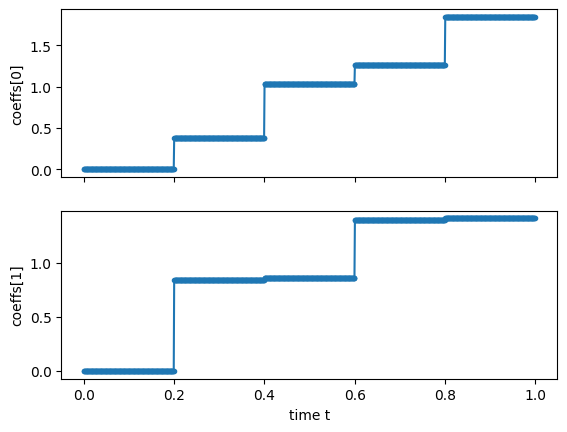

In [14]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [15]:
from datetime import datetime

n_epochs = 200
param_vector = perceptron.get_random_parameter_vector(8098)


# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
# schedule0 = optax.constant_schedule(1)
# schedule1 = optax.constant_schedule(0.1)
# schedule = optax.join_schedules([schedule0, schedule1], [50])
# optimizer = optax.adam(learning_rate=schedule)
optimizer = optax.adam(learning_rate=0.5)
opt_state = optimizer.init(param_vector)

energies = np.zeros(n_epochs )
# energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)

gradients_trajectory = []
param_trajectory = []

## Compile the evaluation and gradient function and report compilation time
time0 = time()
_ = value_and_grad(param_vector)
time1 = time()

# print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)

    mean_gradients[n] = np.mean(np.abs(grads))
    energies[n] = val
    param_trajectory.append(param_vector)
    gradients_trajectory.append(grads)

    param_vector = optax.apply_updates(param_vector, updates)

    if not n % 10:
        print(f"{n+1} / {n_epochs}; Frobenius norm: {val}")
        print(f"    mean grad: {mean_gradients[n]}")
        print(f'    gradient norm: {jnp.linalg.norm(grads)}')
        if n>=2:
            print(f'    difference of gradients: {jnp.linalg.norm(grads-gradients_trajectory[-2])}')


    # if jnp.linalg.norm(gradients_trajectory[n-1] - mean_gradients[n]) < 1e-3:

    #     break


print(f"Optimal Frobenius Norm Found: {energies[-1]}")


1 / 200; Frobenius norm: 5.827234533180288
    mean grad: 0.9603135387369172
    gradient norm: 4.509350944307437
11 / 200; Frobenius norm: 0.34947917514772725
    mean grad: 0.5140688318156781
    gradient norm: 2.281012890036684
    difference of gradients: 2.642984770841844
21 / 200; Frobenius norm: 0.17198487912860683
    mean grad: 0.351849389584491
    gradient norm: 1.6046729202140433
    difference of gradients: 1.2540576473424059
31 / 200; Frobenius norm: 0.02932278886409523
    mean grad: 0.13651427546146827
    gradient norm: 0.6383631886124405
    difference of gradients: 0.9374204546901111
41 / 200; Frobenius norm: 0.031322880371079706
    mean grad: 0.1537712619857567
    gradient norm: 0.6969179100567011
    difference of gradients: 0.5071826135875048
51 / 200; Frobenius norm: 0.011372068574607763
    mean grad: 0.06602346320451902
    gradient norm: 0.40984260943224393
    difference of gradients: 0.34295441337477195
61 / 200; Frobenius norm: 0.0029225298619835727
    m

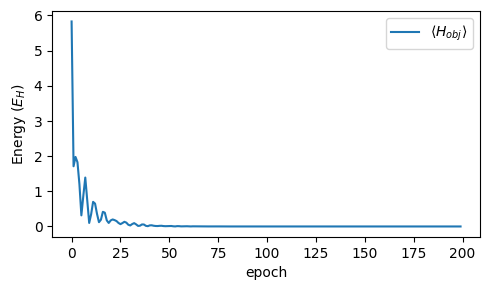

In [16]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energies 
ax.plot(y, label="$\\langle H_{{obj}}\\rangle$")
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

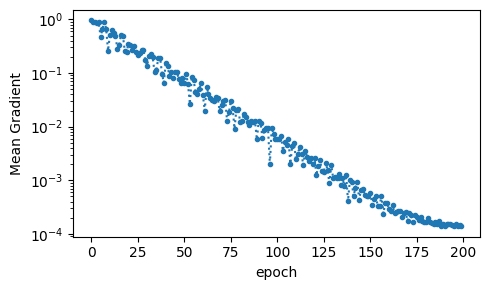

In [17]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

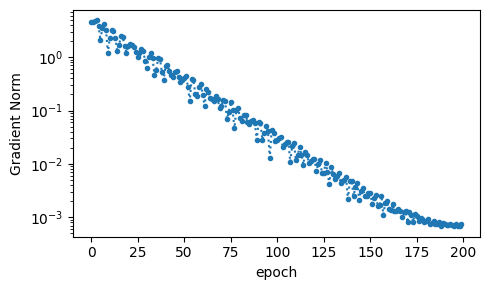

In [18]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradient) for gradient in gradients_trajectory]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Gradient Norm")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

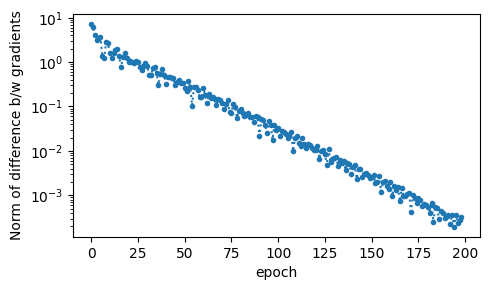

In [19]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradients_trajectory[j] - gradients_trajectory[j-1]) for j in range(1,len(gradients_trajectory))]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Norm of difference b/w gradients")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

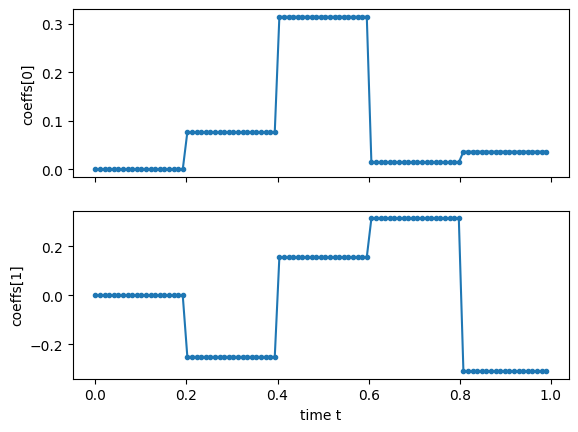

In [20]:
ts = jnp.linspace(0.0, 1, 100)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [21]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

Array([ 7.88372940e+00+0.00000000e+00j,  7.96103309e+00+0.00000000e+00j,
        7.93862469e+00+0.00000000e+00j,  7.92537911e+00+0.00000000e+00j,
        2.39437654e-01+0.00000000e+00j,  2.30232692e-01+0.00000000e+00j,
        2.31274451e-01+0.00000000e+00j,  2.34458869e-01+0.00000000e+00j,
        1.12955109e-03+0.00000000e+00j,  6.63900485e-04+0.00000000e+00j,
        4.68475458e-04+0.00000000e+00j,  3.01498874e-04+0.00000000e+00j,
       -4.01883111e-05+0.00000000e+00j,  7.35905640e-06+0.00000000e+00j,
        8.14634979e-05+2.91536664e-07j,  8.14634979e-05-2.91536664e-07j],      dtype=complex128)

/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


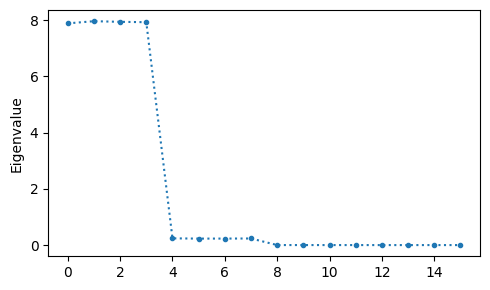

In [22]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()
y

plt.tight_layout()
plt.show()